# VAE para Imagens

Nesse Projeto utilizaremos a técnica de Autoencoders Variocionais no DataSet do Kaggle Dog Breed Indentification

**VAE** pode fazer a geração de dados semelhantes aos de antes. Mas antes de mergulhar no VAE, vamos entender como funciona o **AutoEncoder** simples.

O AutoEncoder consiste em duas partes: redes **codificadoras** e **decodificadoras**.

O codificador recebe seus dados como entrada e produz alguma representação contínua (também conhecida como variável latente) de amostras fornecidas. Essa representação deve ter dimensão menor que os dados. A razão é - o AE deve pegar apenas as informações mais importantes sobre os dados e descartar as não importantes como o PCA, mas neste caso funciona de forma não linear.

O decodificador usa essa representação como entrada e tenta reconstruir os dados originais.

A perda desta rede é alguma distância definida entre a entrada original e a saída reconstruída. Em imagens, geralmente é a perda de entropia cruzada binária em termos de pixel.

## AE variacional 

Há uma pequena mudança na representação latente. Agora o codificador produzuz dois vetores: vetor de médias e vetor de desvios-padrão.

Usando esses vetores de média e padrão, podemos gerar alguma quantidade de novas amostras e propagá-las por meio do decodificador.

## Por que devemos usar VAE, não AE?

VAE é mais complicado e requer conhecimento de matemática. O VAE faz suposições fortes sobre a distribuição da variável latente. É melhor porque os vetores de amostras da mesma classe serão falsos continuamente. Podemos fazer melhor clusterização, interpolação. A geração de novos dados será mais fácil. Se o espaço oculto tivesse lacunas entre os aglomerados, a amostragem desse espaço produziria resultados ruins.

In [2]:
# Driver montado no google colab para poder desfrutar da GPU
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Bibliotecas que serão utilizados no problema
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [4]:
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset

In [5]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
    
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in self.img_names:
            img = Image.open(os.path.join(img_dir, img_name))
            
            if self.transform1 is not None:
                img = self.transform1(img)
                
            self.imgs.append(img)

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

In [6]:
# Primeiro pré-processamento de dados
transform1 = transforms.Compose([transforms.Resize(64),
                                transforms.CenterCrop(64)])

# Aumento de dados e conversão em tensores
random_transforms = [transforms.RandomRotation(degrees=10)]
transform2 = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomApply(random_transforms, p=0.3), 
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                                 
train_dataset = DogDataset(img_dir='/content/drive/MyDrive/dogs/train/',
                           transform1=transform1,
                           transform2=transform2)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Plotando alguns exemplos

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


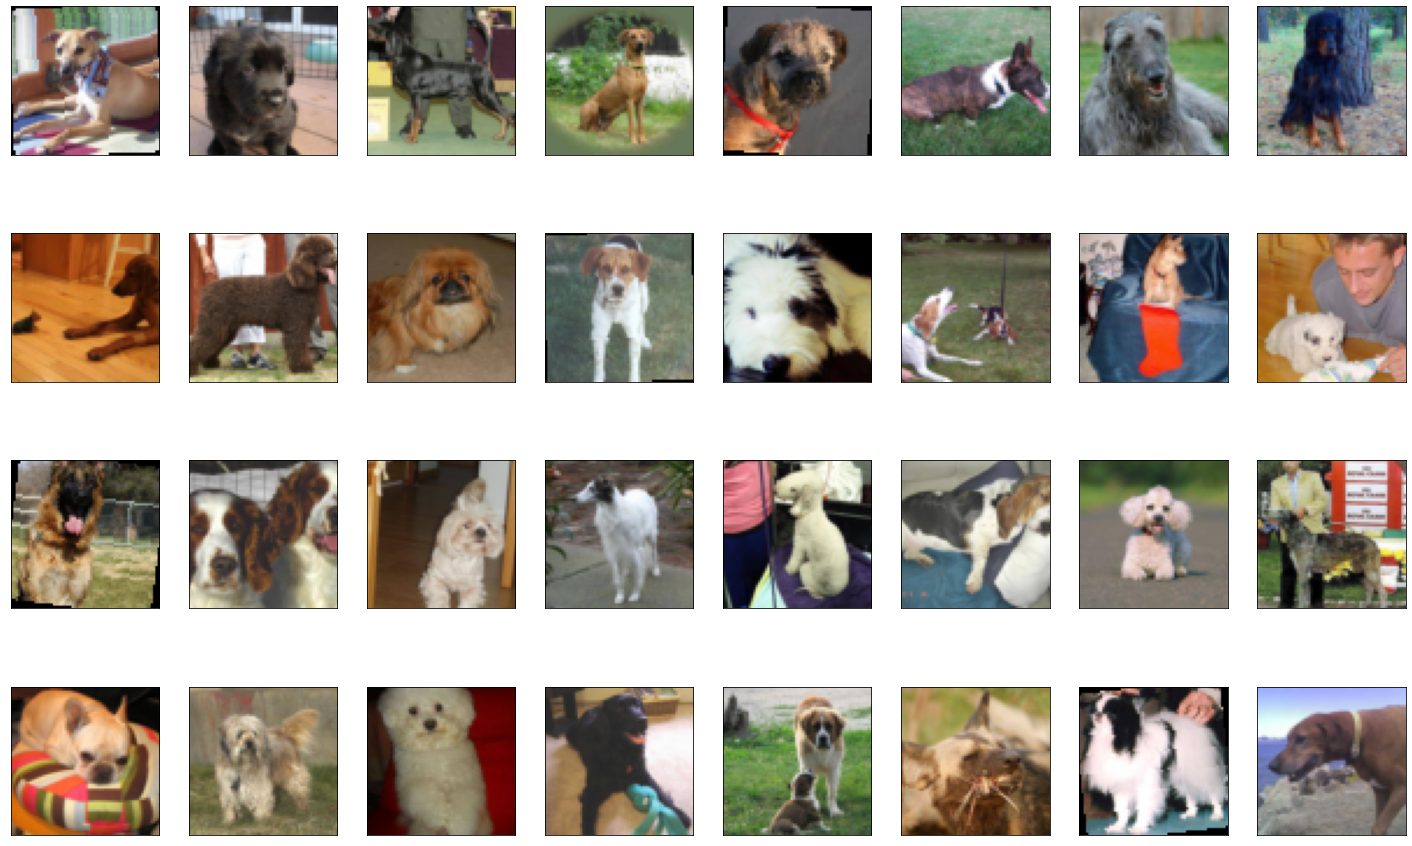

In [7]:
x = next(iter(train_loader))

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(x):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    
    img = img.numpy().transpose(1, 2, 0)
    plt.imshow((img+1.)/2.)

### Modelo VAE
O código abaixo é baseado em https://github.com/atinghosh/VAE-pytorch

In [8]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128, no_of_sample=10, batch_size=32, channels=3):
        super(VAE, self).__init__()
        
        self.no_of_sample = no_of_sample
        self.batch_size = batch_size
        self.channels = channels
        self.latent_dim = latent_dim
        
        
        # Encoder
        def convlayer_enc(n_input, n_output, k_size=4, stride=2, padding=1, bn=False):
            block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
            if bn:
                block.append(nn.BatchNorm2d(n_output))
            block.append(nn.LeakyReLU(0.2, inplace=True))
            return block
        
        self.encoder = nn.Sequential(
            *convlayer_enc(self.channels, 64, 4, 2, 2),               # (64, 32, 32)
            *convlayer_enc(64, 128, 4, 2, 2),                         # (128, 16, 16)
            *convlayer_enc(128, 256, 4, 2, 2, bn=True),               # (256, 8, 8)
            *convlayer_enc(256, 512, 4, 2, 2, bn=True),               # (512, 4, 4)
            nn.Conv2d(512, self.latent_dim*2, 4, 1, 1, bias=False),   # (latent_dim*2, 4, 4)
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        
        # Decoder
        def convlayer_dec(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),
            ]
            return block
        
        self.decoder = nn.Sequential(
            *convlayer_dec(self.latent_dim, 512, 4, 2, 1),           # (512, 8, 8)
            *convlayer_dec(512, 256, 4, 2, 1),                       # (256, 16, 16)
            *convlayer_dec(256, 128, 4, 2, 1),                       # (128, 32, 32)
            *convlayer_dec(128, 64, 4, 2, 1),                        # (64, 64, 64)
            nn.ConvTranspose2d(64, self.channels, 3, 1, 1),          # (3, 64, 64)
            nn.Sigmoid()
        )

    def encode(self, x):
        '''return mu_z and logvar_z'''
        x = self.encoder(x)
        return x[:, :self.latent_dim, :, :], x[:, self.latent_dim:, :, :]
    
    def decode(self, z):
        z = self.decoder(z)
        return z.view(-1, 3 * 64 * 64)

    def reparameterize(self, mu, logvar):
        if self.training:
            # multiplica a variação logarítmica por 0,5 e, em seguida, expoente no local
            # produzindo o desvio padrão

            sample_z = []
            for _ in range(self.no_of_sample):
                std = logvar.mul(0.5).exp_()
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))
            return sample_z
        
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 3 * 64 * 64))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 3 * 64 * 64))

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        KLD /= self.batch_size * 3 * 64 * 64

        return BCE + KLD

Dim de entrada é 64 x 64 x 3 = 12288

A penumbra latente é 4 x 4 x 32 = 512

O gargalo é 24 vezes menor do que a imagem de entrada! O Autoencoder deve manter as informações mais importantes

In [9]:
lr = 0.001
epochs = 50
latent_dim = 32

model = VAE(latent_dim, batch_size=batch_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

### Imagem Para Validação

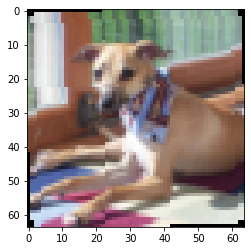

In [10]:
plt.imshow((x[0].numpy().transpose(1, 2, 0)+1)/2)
plt.show()

# Treinamento

Epoch 1 start


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


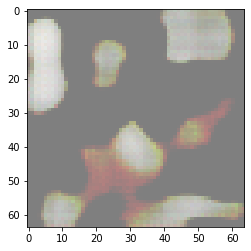

Epoch 2 start


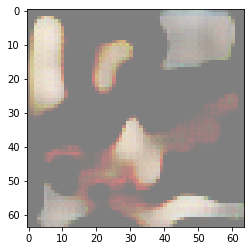

Epoch 3 start


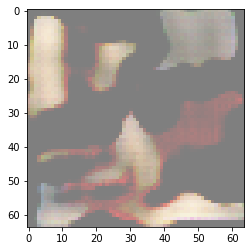

Epoch 4 start


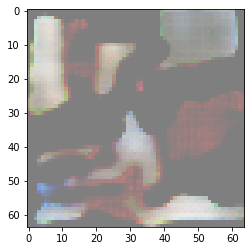

Epoch 5 start


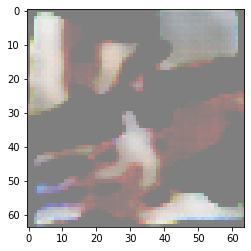

Epoch 6 start


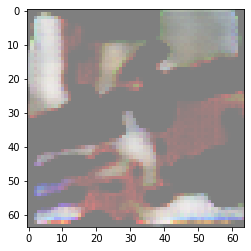

Epoch 7 start


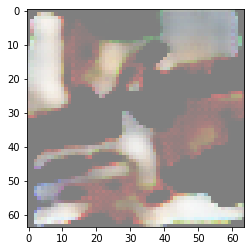

Epoch 8 start


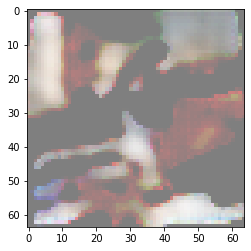

Epoch 9 start


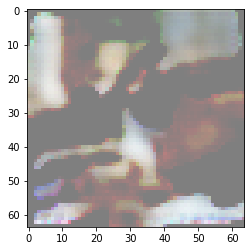

Epoch 10 start


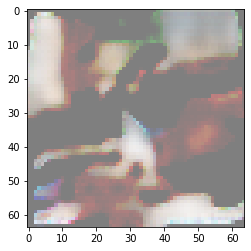

Epoch 11 start


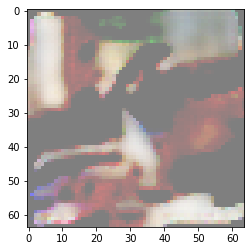

Epoch 12 start


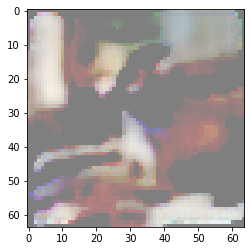

Epoch 13 start


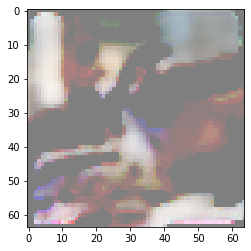

Epoch 14 start


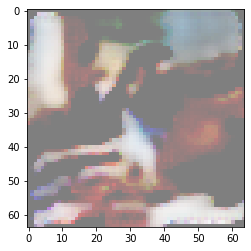

Epoch 15 start


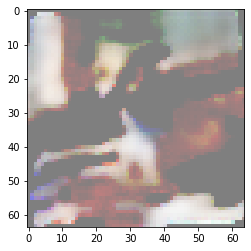

Epoch 16 start


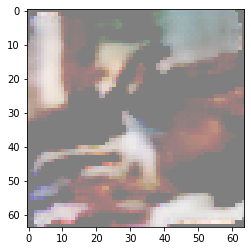

Epoch 17 start


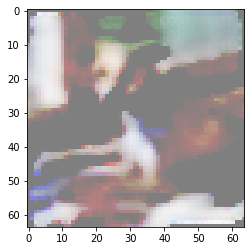

Epoch 18 start


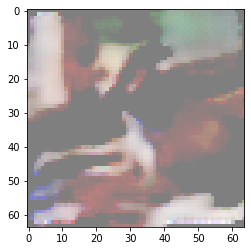

Epoch 19 start


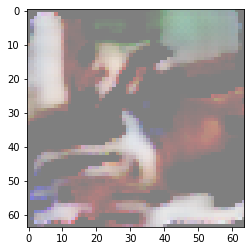

Epoch 20 start


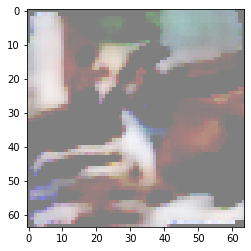

Epoch 21 start


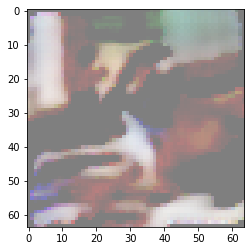

Epoch 22 start


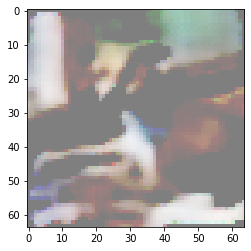

Epoch 23 start


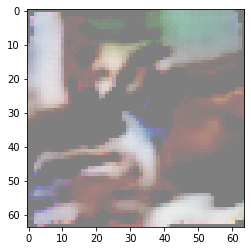

Epoch 24 start


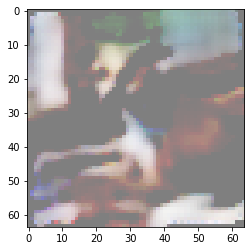

Epoch 25 start


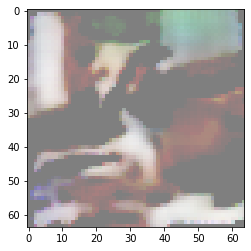

Epoch 26 start


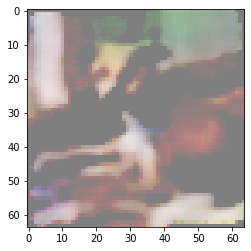

Epoch 27 start


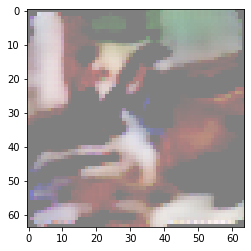

Epoch 28 start


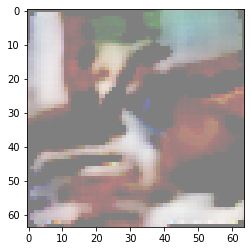

Epoch 29 start


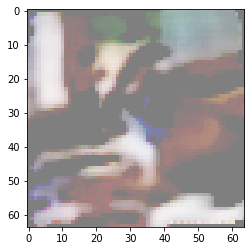

Epoch 30 start


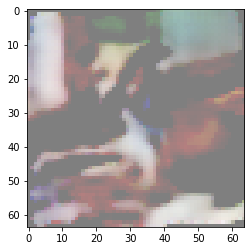

Epoch 31 start


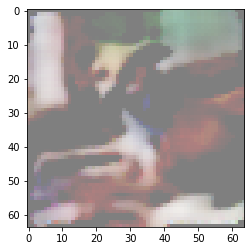

Epoch 32 start


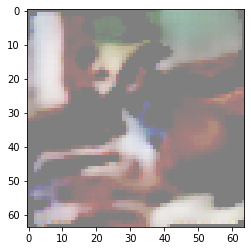

Epoch 33 start


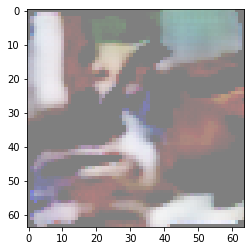

Epoch 34 start


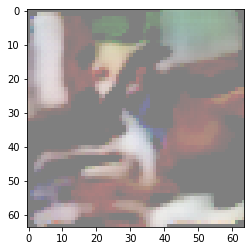

Epoch 35 start


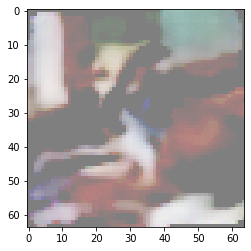

Epoch 36 start


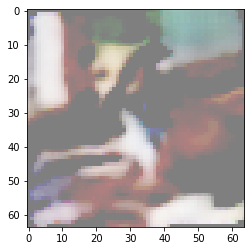

Epoch 37 start


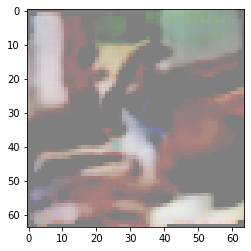

Epoch 38 start


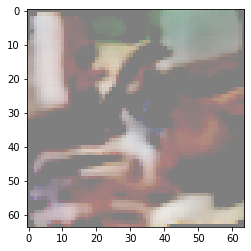

Epoch 39 start


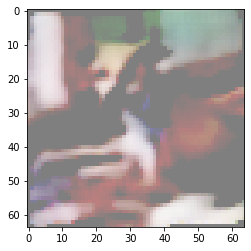

Epoch 40 start


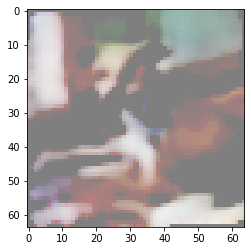

Epoch 41 start


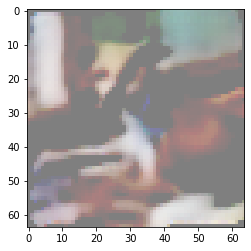

Epoch 42 start


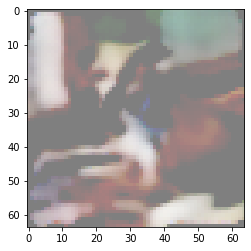

Epoch 43 start


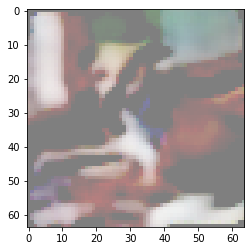

Epoch 44 start


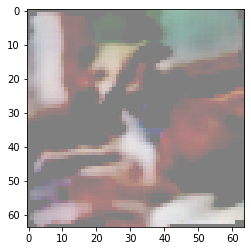

Epoch 45 start


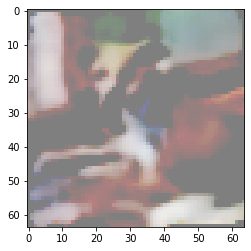

Epoch 46 start


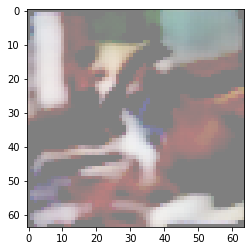

Epoch 47 start


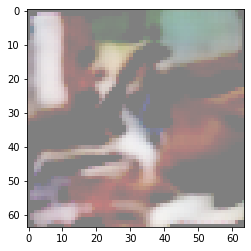

Epoch 48 start


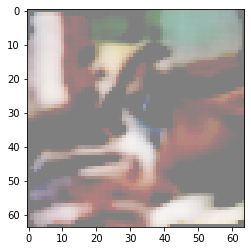

Epoch 49 start


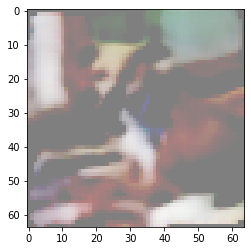

Epoch 50 start


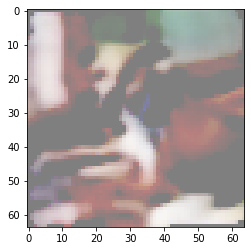

In [11]:
for epoch in range(1, epochs+1):
    model.train()
    print(f'Epoch {epoch} start')
    
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = model.loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        optimizer.step()
        
    model.eval()
    recon_img, _, _ = model(x[:1].to(device))
    img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
    
    plt.imshow((img+1.)/2.)
    plt.show()

### Verificando o quão bão ficou as imagens de reconstrução VAE

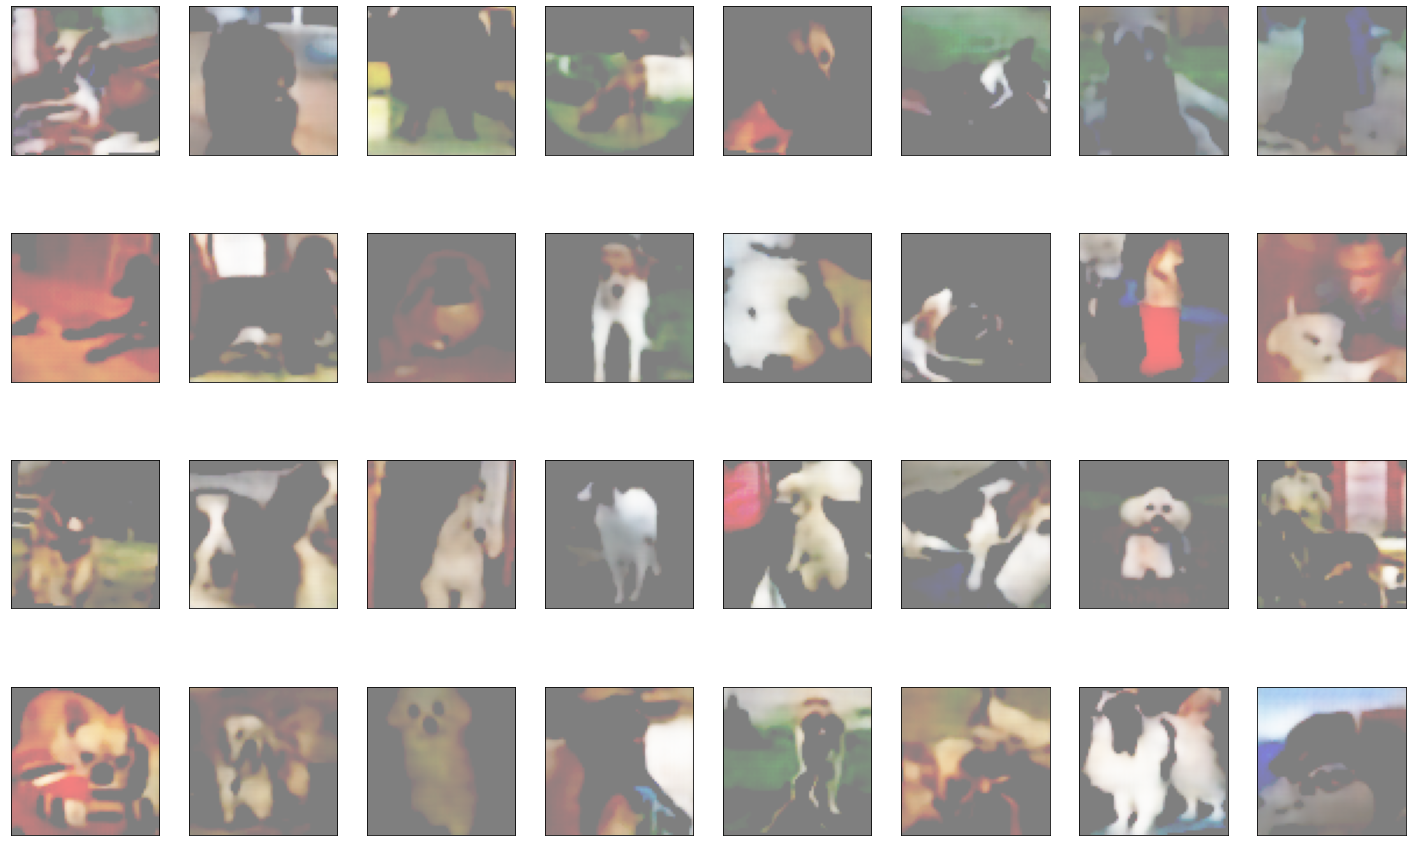

In [12]:
reconstructed, mu, _ = model(x.to(device))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

### Geração do espaço latente de um cachorro para outro

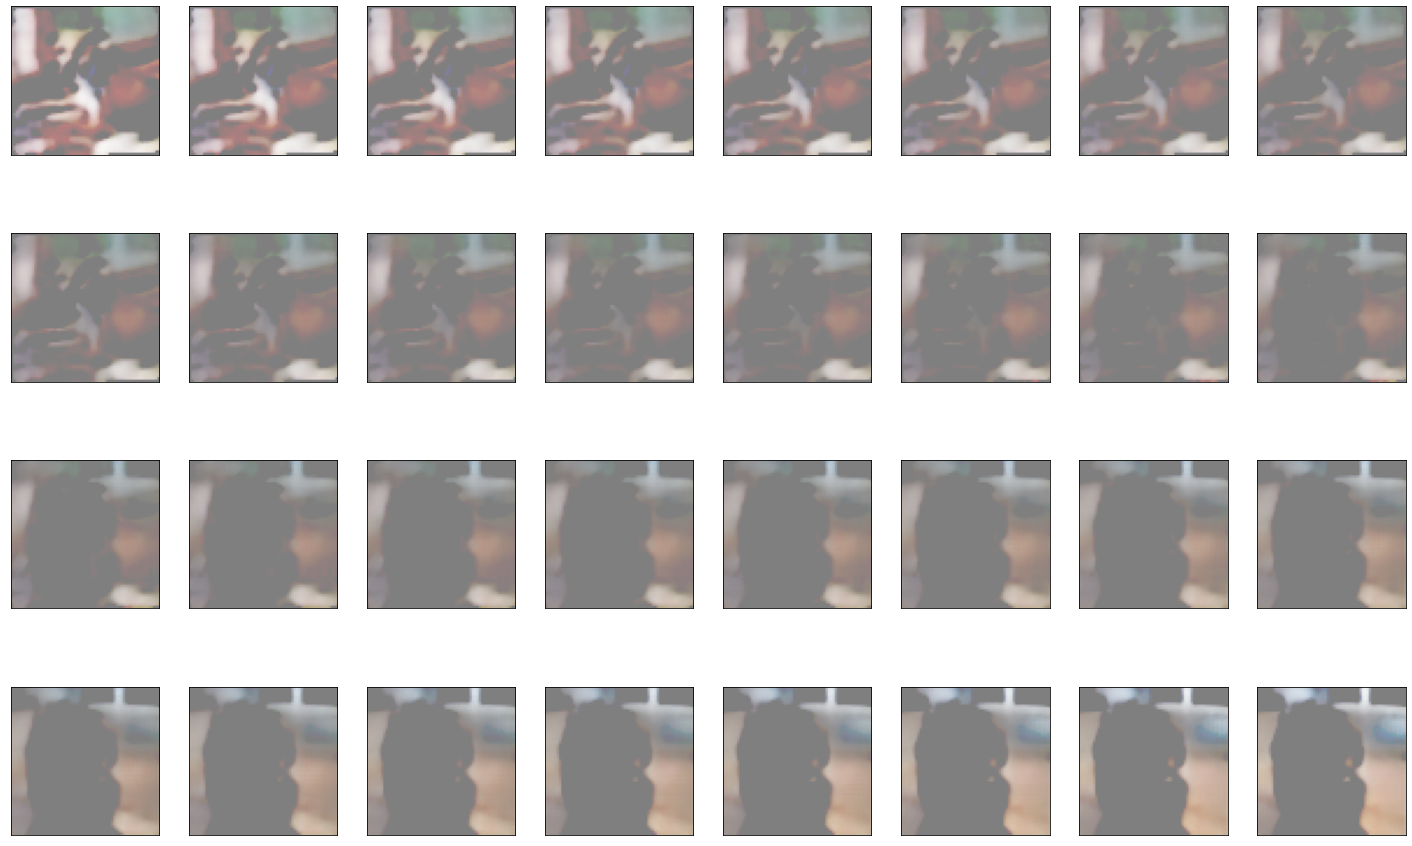

In [13]:
first_dog_idx = 0
second_dog_idx = 1

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)

### Geração de  ruído aleatório e execução do decodificador neste

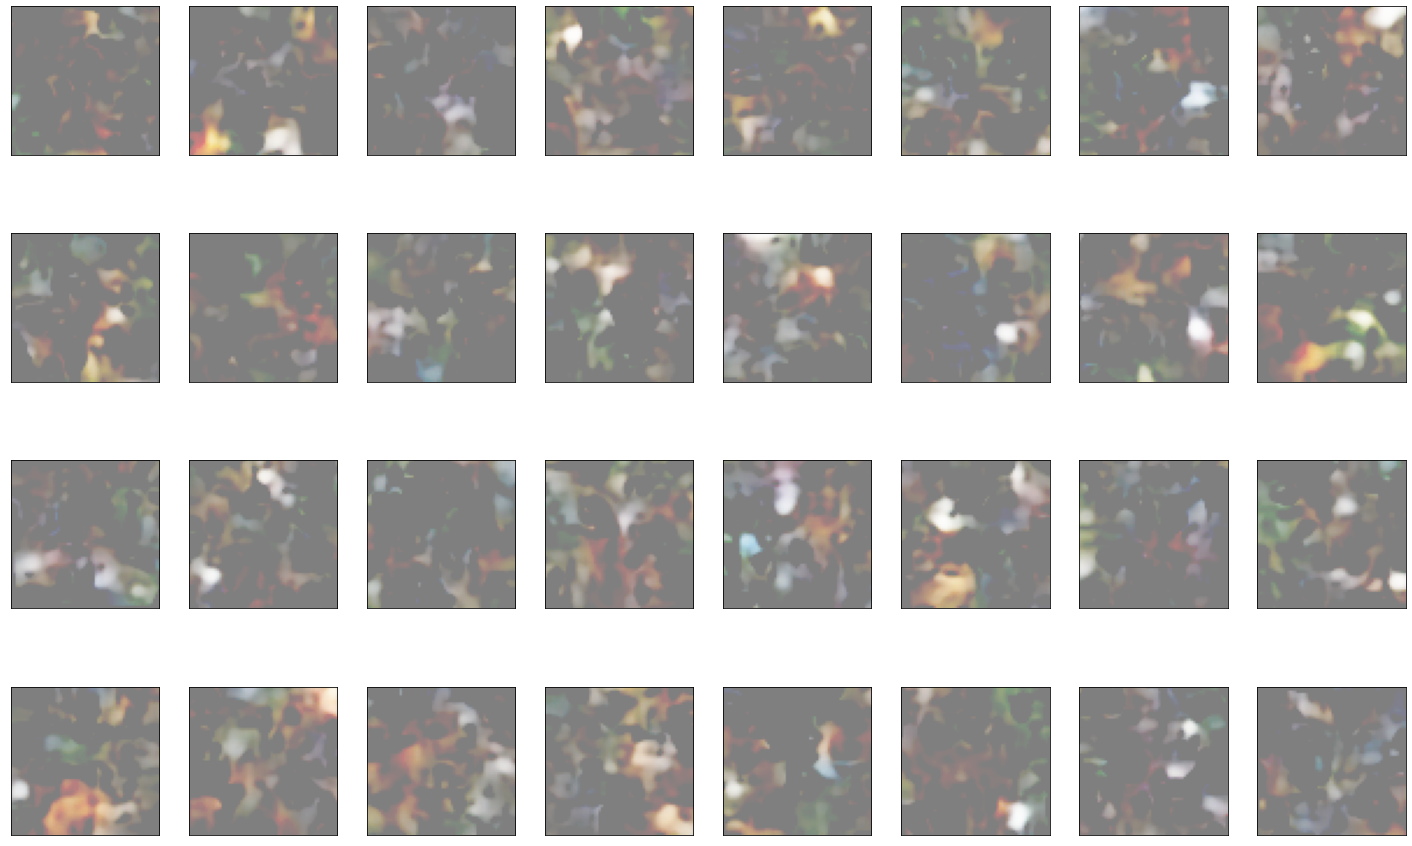

In [14]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(device)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img+1.)/2.)